### trying out functions 

In [1]:
import numpy as np 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.path import Path

def remove_polygon_from_array(array, xmin = np.nan, xmax= np.nan, ymin= np.nan, ymax= np.nan):
    plt.imshow(array, cmap='bwr', origin='lower')
        
    if not np.isnan(xmin):
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

    plt.colorbar()
    plt.title('Original Array')

    # Allowing user to draw a polygon on the plot
    polygon_path = plt.ginput(n=-1, show_clicks=True)
    plt.close()

    # Creating a Path object from the polygon points
    polygon_vertices = [point for point in polygon_path]
    polygon_path = Path(polygon_vertices)

    # Creating a mask to identify points within the polygon
    x, y = np.indices(array.shape)
    points = np.column_stack((y.flatten(), x.flatten()))
    mask = polygon_path.contains_points(points)
    mask = mask.reshape(array.shape)

    # Removing the area within the polygon by setting values to zero
    array[mask] = np.nan

    # Displaying the modified array
    plt.imshow(array, cmap='viridis', origin='lower')
    plt.colorbar()
    plt.title('Modified Array')

    plt.show()

In [ ]:
### Following are how to run the different function 

In [5]:
# Sample latitude, longitude in decimal degrees
# Each column represents a data point
llh = np.array([[34.05, 34.10, 34.15],  # Latitude values
                [-118.24, -118.20, -118.10]])  # Longitude values

# Latitude of origin in decimal degrees
ll_org = np.array([34.10, -118.20])

# Call the llh2localxy function
xy = llh2localxy(llh, ll_org)

# Print the result
print("Local XY Coordinates (in km):")
print(xy)

Local XY Coordinates (in km):
[[-3.70344969 -5.54602705]
 [-0.          0.        ]
 [ 9.24777988  5.54607278]]


In [7]:
import matplotlib
matplotlib.use('TkAgg')

# Create a sample array (replace this with your actual data)
array = np.random.rand(100, 100)

# Define the bounding box for the polygon (xmin, xmax, ymin, ymax)
xmin = 20
xmax = 80
ymin = 30
ymax = 70

# Call the function to remove the polygon from the array
remove_polygon_from_array(array, xmin, xmax, ymin, ymax)

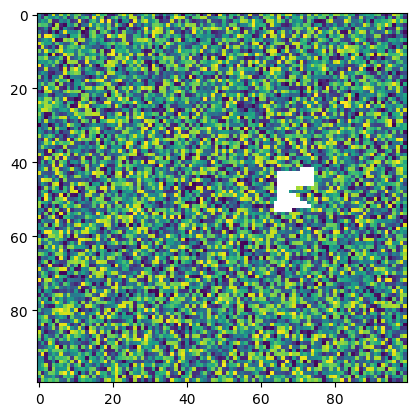

In [8]:
%matplotlib inline

plt.imshow(array)